In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/2023_Data_Mining_Physics_vs_Chemistry_vs_Biology_Dataset/klasifikacija

/content/drive/MyDrive/Colab Notebooks/2023_Data_Mining_Physics_vs_Chemistry_vs_Biology_Dataset/klasifikacija


# Klasifikacija
ovde ide neki tekst kao opis problema + napomena da je dataset automatski na trening i test podeljen

# Ucitavanje i analiza skupa podataka

In [4]:
data = pd.read_csv('../dataset/train.csv')
rows, columns = data.shape
print(f'Num of rows: {rows}')
print(f'Num of columns: {columns}')
print(f'The dataset has the following attribute names: {list(data.columns)}')

Num of rows: 8695
Num of columns: 3
The dataset has the following attribute names: ['Id', 'Comment', 'Topic']


In [5]:
pd.options.display.max_colwidth = 1000
data.head()

#data.drop('Id', axis=1, inplace=True)

,Id,Comment,Topic
0,0x840,"A few things. You might have negative- frequency dependent selection going on where the least common phenotype, reflected by genotype, is going to have an advantage in the environment. For instance, if a prey animal such as a vole were to have a light and a dark phenotype, a predator might recognize the more common phenotype as food. So if the light voles are more common, foxes may be keeping a closer eye out for light phenotypic voles, recognising them as good prey. This would reduce the light causing alleles due to increased predation and the dark genotypes would increase their proportion of the population until this scenario is reversed. This cycle continues perpetually. \n\nHowever, this is unlikely to be strictly yearly as it usually takes more time than a year for an entire populations allele frequencies to change enough to make a large enough difference to alter fitness. \n\nMore likely on a *year to year* basis, the population is experiencing fluctuating selection where al...",Biology
1,0xbf0,Is it so hard to believe that there exist particulars out that that we can't detect with anything we've invented so far.\n\nI mean look how long it took humans to find out a way to detect radiation.,Physics
2,0x1dfc,There are bees,Biology
3,0xc7e,I'm a medication technician. And that's alot of drugs on your liver. You probably won't die immediately you'll be fine. Take care of your self tho that's definitely not good for your body,Biology
4,0xbba,Cesium is such a pretty metal.,Chemistry


neki komentar kako je id nebitan zato ga izbacujem, klasifikacija na osnovu comment, dugacki komentari sve je tekst treba bas da se sredi, topic 3 kategoricki

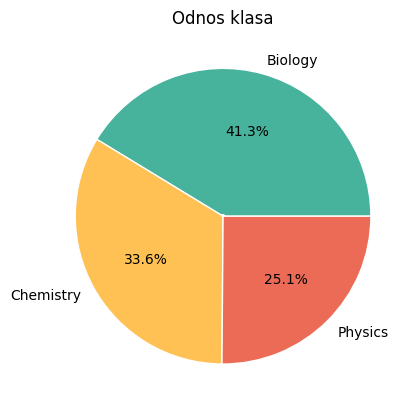

In [6]:
counts = data['Topic'].value_counts()

spacing = 1.01
wedgeprops = {'width': spacing, 'edgecolor': 'w'}
colors = ['#47b39c', '#ffc154', '#ec6b56']
counts.plot(kind='pie', colors=colors, autopct='%1.1f%%', wedgeprops=wedgeprops)
plt.title('Odnos klasa')
plt.ylabel('')
plt.show()

Text(0.5, 1.0, 'Biology')

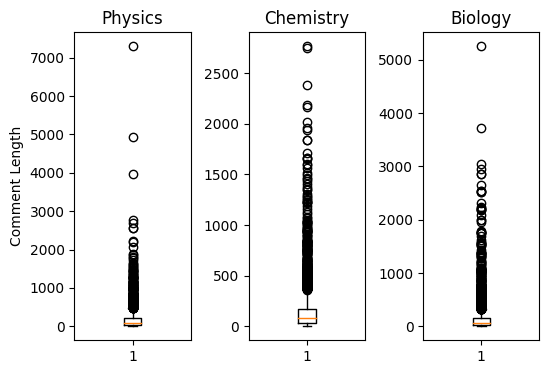

In [7]:
# outliers

comments = data['Comment']
topics = data['Topic']

comment_lengths = comments.str.len()

physics_lengths = sorted(comment_lengths[topics == 'Physics'])
chemistry_lengths = sorted(comment_lengths[topics == 'Chemistry'])
biology_lengths = sorted(comment_lengths[topics == 'Biology'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 4))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 3, 1)
plt.boxplot(physics_lengths)
plt.title('Physics')
plt.ylabel('Comment Length')

plt.subplot(1, 3, 2)
plt.boxplot(chemistry_lengths)
plt.title('Chemistry')

plt.subplot(1, 3, 3)
plt.boxplot(biology_lengths)
plt.title('Biology')

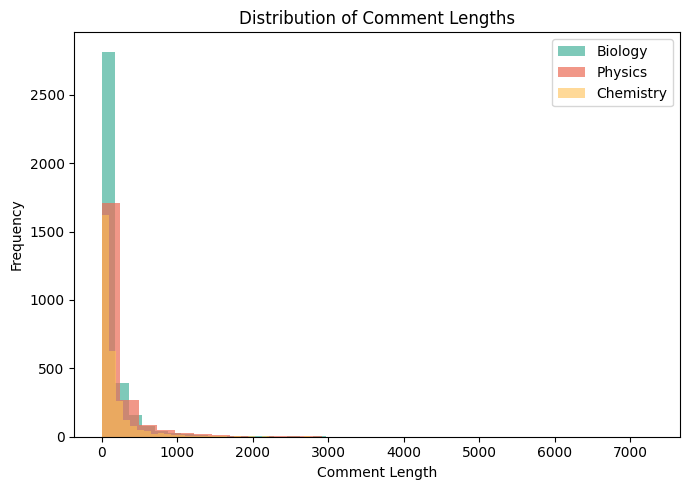

In [8]:
plt.figure(figsize=(7, 5))

plt.hist(biology_lengths, bins=30, color='#47b39c', alpha=0.7, label='Biology')
plt.hist(physics_lengths, bins=30, color='#ec6b56', alpha=0.7, label='Physics')
plt.hist(chemistry_lengths, bins=30, color='#ffc154', alpha=0.6, label='Chemistry')

plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# insanely irrelevant for anything al neka za sad

all_comments = [biology_lengths, physics_lengths, chemistry_lengths]

metrics = []
for comments in all_comments:
    metrics.append({
        'mean': np.mean(comments),
        'median': np.median(comments),
        'std_dev': np.std(comments),
        'range': np.ptp(comments)
    })
    
for i, metric in enumerate(metrics):
    category_num = i + 1
    print(f"Category {category_num} Metrics:")
    print("Mean:", metric['mean'])
    print("Median:", metric['median'])
    print("Standard Deviation:", metric['std_dev'])
    print("Range:", metric['range'])
    print()

Category 1 Metrics:
Mean: 161.67947646895016
Median: 71.0
Standard Deviation: 295.2210920631285
Range: 5245

Category 2 Metrics:
Mean: 197.6959706959707
Median: 93.5
Standard Deviation: 350.2851128915344
Range: 7297

Category 3 Metrics:
Mean: 157.39383561643837
Median: 79.0
Standard Deviation: 243.56339298087582
Range: 2764



# Rad sa nedostajucim vrednostima
Mozemo da proverimo da li ima null/NaN al dataset je takav da su nam 'nedostajuce' removed ili deleted al mozemo ih nekako obraditi

In [10]:
data.isna().any().any()

False

In [11]:
data.isin(['[removed]']).any().any()

True

In [12]:
data.isin(['[deleted]']).any().any()

True

In [13]:
count_removed = (data['Comment'] == '[removed]').sum()
count_deleted = (data['Comment'] == '[deleted]').sum()

removed_rows = data[data['Comment'] == '[removed]']
deleted_rows = data[data['Comment'] == '[deleted]']

In [14]:
deleted_rows # korisnik je sam obrisao komentar

,Id,Comment,Topic
46,0x1a29,[deleted],Chemistry
162,0x1a1d,[deleted],Biology
316,0x1725,[deleted],Physics
422,0x32,[deleted],Physics
539,0x2d8,[deleted],Physics
...,...,...,...
7835,0x2550,[deleted],Chemistry
7913,0x20a0,[deleted],Biology
7949,0xda8,[deleted],Physics
8056,0x1cf8,[deleted],Biology


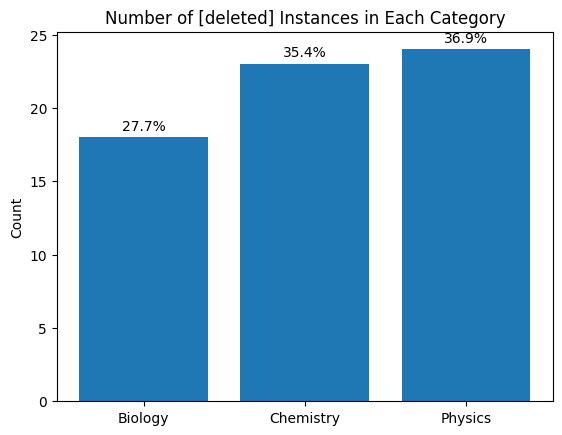

In [15]:
grouped_df = deleted_rows.groupby('Topic').size().reset_index(name='Count')
grouped_df['Percentage'] = (grouped_df['Count'] / count_deleted) * 100

plt.bar(grouped_df['Topic'], grouped_df['Count'])
plt.ylabel('Count')
plt.title('Number of [deleted] Instances in Each Category')

for i, count in enumerate(grouped_df['Count']):
    percentage = grouped_df.loc[i, 'Percentage']
    plt.text(i, count + 0.5, f'{percentage:.1f}%', ha='center')
    
plt.show()

In [16]:
removed_rows # mod said no 

,Id,Comment,Topic
36,0x1b1,[removed],Physics
84,0x1804,[removed],Physics
86,0x1fea,[removed],Physics
108,0x819,[removed],Physics
115,0x12dd,[removed],Physics
...,...,...,...
8201,0x220d,[removed],Physics
8355,0xe36,[removed],Physics
8394,0x242f,[removed],Physics
8421,0x19d1,[removed],Physics


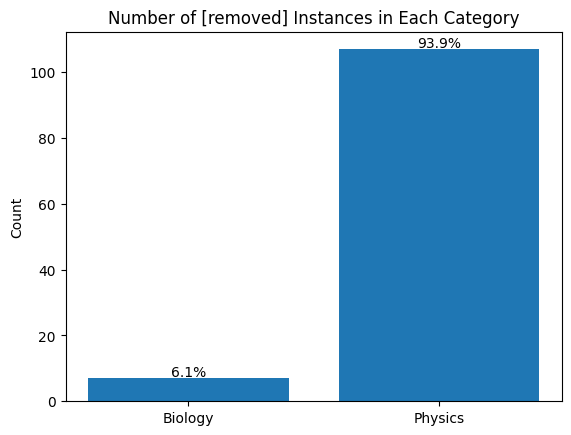

In [17]:
grouped_df = removed_rows.groupby('Topic').size().reset_index(name='Count')
grouped_df['Percentage'] = (grouped_df['Count'] / count_removed) * 100


plt.bar(grouped_df['Topic'], grouped_df['Count'])
plt.ylabel('Count')
plt.title('Number of [removed] Instances in Each Category')

for i, count in enumerate(grouped_df['Count']):
    percentage = grouped_df.loc[i, 'Percentage']
    plt.text(i, count + 0.5, f'{percentage:.1f}%', ha='center')

plt.show()

In [18]:
cleaned_data = data.drop(data[(data['Comment'] == '[removed]') | (data['Comment'] == '[deleted]')].index)

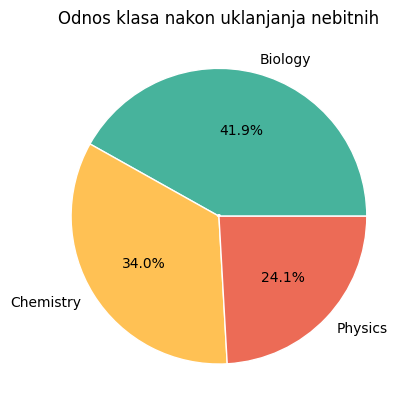

In [19]:
counts = cleaned_data['Topic'].value_counts()

spacing = 1.01
wedgeprops = {'width': spacing, 'edgecolor': 'w'}
colors = ['#47b39c', '#ffc154', '#ec6b56']
counts.plot(kind='pie', colors=colors, autopct='%1.1f%%', wedgeprops=wedgeprops)
plt.title('Odnos klasa nakon uklanjanja nebitnih')
plt.ylabel('')
plt.show()

meni je ovo ok 🤔

# Pretprocesiranje

In [20]:
# The TF-IDF features can capture the importance of individual terms, while the word 
# embeddings can capture the meaning of the text.

In [21]:
file_path = "output.txt"  
with open(file_path, 'r') as file:
    additional_stop_words = [line.strip() for line in file]

In [22]:
def preprocess(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() # sve u mala slova
    cleanr = re.compile(r'[^A-Za-z0-9 \']+') # uklanjanje sve sem alfanumerickih i apostrofa
    cleantext = re.sub(cleanr, ' ', sentence)
    cleantext = re.sub(r"\b\d+\b", "", cleantext)
     
    common_stopwords = set(stopwords.words('english'))
    common_stopwords.update(['http', 'https', 'www', 'com', 'yeah'])
    common_stopwords.update(additional_stop_words)
    
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(cleantext) # tokenizacija
    
    tokens = [t for t in tokens if not t in common_stopwords] # uklanjanje nebitnih
    
    lemmatizer = WordNetLemmatizer()   
    tokens = [lemmatizer.lemmatize(t) for t in tokens] # lematizacija
    
    return tokens

In [23]:
# izgled nakon pretprocesiranja

df = data.copy()
df["Processed Comments"] = df["Comment"].apply(preprocess).apply(lambda x: " ".join(x))

df_show = df.drop('Id', axis=1)
df_show = df_show.drop('Topic', axis=1)
df_show.head(10)

,Comment,Processed Comments
0,"A few things. You might have negative- frequency dependent selection going on where the least common phenotype, reflected by genotype, is going to have an advantage in the environment. For instance, if a prey animal such as a vole were to have a light and a dark phenotype, a predator might recognize the more common phenotype as food. So if the light voles are more common, foxes may be keeping a closer eye out for light phenotypic voles, recognising them as good prey. This would reduce the light causing alleles due to increased predation and the dark genotypes would increase their proportion of the population until this scenario is reversed. This cycle continues perpetually. \n\nHowever, this is unlikely to be strictly yearly as it usually takes more time than a year for an entire populations allele frequencies to change enough to make a large enough difference to alter fitness. \n\nMore likely on a *year to year* basis, the population is experiencing fluctuating selection where al...",thing negative frequency dependent selection common phenotype reflected genotype advantage environment instance prey animal vole dark phenotype predator recognize common phenotype food vole common fox keeping closer eye phenotypic vole recognising prey reduce causing allele due increased predation dark genotype increase proportion population scenario reversed cycle continues perpetually n nhowever unlikely strictly yearly take entire population allele frequency large difference alter fitness n nmore basis population experiencing fluctuating selection alternating condition environment favor genotype perhaps plant specie living area flooded phenotype population plant dryer wet flooding dry genotype fitness leading offspring therefore dry allele population flooded year wet liking phenotype propagate wet gene
1,Is it so hard to believe that there exist particulars out that that we can't detect with anything we've invented so far.\n\nI mean look how long it took humans to find out a way to detect radiation.,exist particular detect invented n took human detect radiation
2,There are bees,bee
3,I'm a medication technician. And that's alot of drugs on your liver. You probably won't die immediately you'll be fine. Take care of your self tho that's definitely not good for your body,medication technician alot drug liver die immediately fine care self tho
4,Cesium is such a pretty metal.,cesium metal
5,I meant that the question itself is unclear.,meant unclear
6,Shove it up your ass and see what happens,shove as happens
7,"??? I mean it has some butter, but besides that it’s sugar, baking soda, and peanuts, so yeah…",butter besides sugar baking soda peanut
8,https://t.me/joinchat/3gElLHLuMCxhNGI0,joinchat 3gellhlumcxhngi0
9,"Well, that’s just the thing. You can’t really induce an immune response against yourself by introducing a protein that’s already there.",induce immune response introducing protein


In [24]:
# ne smemo da sklonimo gibberish oblika 3gellhlumcxhngi0 zbog hemije
# ne sklanjam sajtove jer mogu biti dati kao resource za nesto te sadrzati bitne reci

# TF IDF matrica

In [25]:
# enkodiranje klasa
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_topics = one_hot_encoder.fit_transform(df[['Topic']])

# pravljenje tf idf matrice
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df["Processed Comments"])

# izvlacenje imena kolona
tfidf_feature_names = vectorizer.get_feature_names_out()
topic_names = one_hot_encoder.get_feature_names_out()

# konacna reprezentacija za model
tfidf_df = pd.concat([pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names),
                             pd.DataFrame(encoded_topics, columns=topic_names)], axis=1)

tfidf_df.head(10)

,000btu,000g,000x68,0123v1,01pm,020e23,021e23,02e23molecules,02x10,037026938390638x,...,zubairy,zurich,zwitterion,zy,zygomatic,zyklon,zz,Topic_Biology,Topic_Chemistry,Topic_Physics
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [27]:
tfidf_df.to_csv('train_data_tfidf.csv', index=False)

# Word embeddings

In [28]:
df = data.copy()

In [29]:
#pretrained google model
model_path = "GoogleNews-vectors-negative300.bin.gz"
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [30]:
#my model
sentences = df["Comment"].apply(preprocess)
my_model = Word2Vec(sentences, vector_size=300) # jer guglov koristi 300

In [31]:
my_similarity = my_model.wv.similarity('chemistry', 'biology')
pretrained_similarity = model.similarity('chemistry', 'biology')

In [32]:
print(my_similarity, pretrained_similarity) # necu da klase budu slicne, koristicu guglov 

0.9998464 0.45998442


In [33]:
def embed_comment(tokens):
    embeddings = []
    for token in tokens:
        if token in model:
            embeddings.append(model[token])
    if embeddings:
        embedded_vector = np.mean(embeddings, axis=0)
    else:
        embedded_vector = np.zeros(model.vector_size) # ako se rec ne nalazi u modelu stavlja mu se defaultna vr 0
    return embedded_vector

In [34]:
df["Embedded_comment"] = df["Comment"].apply(preprocess).apply(embed_comment)

embedded_df = pd.concat([df["Embedded_comment"], pd.DataFrame(encoded_topics, columns=topic_names)], axis=1)
embedded_df.head(3)

,Embedded_comment,Topic_Biology,Topic_Chemistry,Topic_Physics
0,"[0.017295456, 0.09365509, -0.073467255, 0.070739746, -0.09224926, -0.06571442, 0.017980346, -0.046699524, 0.09731629, 0.072517395, -0.04024761, -0.12085869, -0.0049313353, 0.04523224, -0.17002915, 0.06776947, -0.079855196, 0.13363831, 0.005877857, -0.12328857, -0.011260681, -0.064128116, -0.029715575, 0.003670807, -0.06895981, -0.10713974, -0.17767043, 0.10338341, 0.023089342, -0.009708595, 0.012624435, -0.085105136, -0.01995636, 0.038846627, -0.114883766, -0.026156768, -0.005567627, 0.0044454955, 0.010348053, 0.12368744, 0.115170725, 0.013017273, -0.002188263, 0.055963326, -0.015148068, -0.17067139, 0.034568787, 0.014897995, -0.100170285, -0.021603126, -0.027266998, -0.07867981, -0.056012325, -0.08433809, 0.049100608, 0.042540893, -0.089077145, -0.09568283, 0.060386866, 0.02665513, 0.00039756775, 0.054337233, -0.11454542, -0.07298832, 0.008918457, -0.056293335, 0.0050619505, 0.096304625, -0.055323485, 0.014950561, 0.021419602, -0.0827591, 0.051393434, 0.007567139, -0.10940246, -0....",1.0,0.0,0.0
1,"[-0.006354438, -0.00012207031, 0.09011502, 0.026119657, -0.20811632, 0.005910238, 0.06385464, -0.07042609, 0.043836806, -0.022772895, -0.003065957, -0.10359701, -0.077690974, -0.028578017, -0.0984158, 0.17800564, -0.062472872, 0.23299493, -0.0403205, -0.046413846, -0.15521918, -0.00021701389, -0.023919, -0.011121962, -0.06894938, -0.06980048, -0.14479573, 0.0061306423, -0.08393012, -0.10369195, -0.13891612, -0.13691966, -0.033915203, -0.13449436, -0.06467014, -0.04703776, -0.055664062, -0.07824029, 0.062025283, 0.06954786, 0.07554796, 0.11501736, 0.038021512, -0.036458332, -0.033359103, -0.096462674, -0.081976995, -0.01047092, -0.06526693, -0.026611328, -0.1280382, -0.06077745, -0.025580512, -0.03253852, -0.11899143, 0.06024848, 0.026275635, -0.111857094, 0.10194227, -0.030229356, -0.037821453, 0.08325873, 0.0015631781, -0.046440974, 0.033935547, -0.034478083, -0.07904731, 0.19196235, -0.082722984, 0.0375434, 0.09613122, 0.020263672, 0.09467231, 0.017089844, -0.26130167, -0.1458570...",0.0,0.0,1.0
2,"[-0.22949219, 0.03564453, -0.41601562, 0.19238281, -0.10986328, -0.06591797, -0.123046875, 0.17773438, 0.0068359375, -0.18457031, 0.10498047, -0.30859375, -0.24609375, -0.10058594, -0.07421875, 0.125, -0.0625, 0.09082031, 0.0625, 0.12158203, 0.034179688, 0.32226562, -0.07128906, -0.015991211, -0.31445312, -0.052246094, -0.14355469, -0.19238281, 0.36132812, 0.032958984, -0.3046875, -0.19335938, 0.07324219, -0.11816406, 0.080566406, 0.0390625, 0.01373291, 0.05126953, 0.24121094, 0.45703125, 0.20019531, -0.29101562, 0.12060547, 0.26953125, -0.21875, -0.15136719, 0.22363281, -0.044189453, 0.18847656, 0.38085938, -0.14257812, -0.16699219, 0.118652344, -0.14453125, 0.13769531, -0.13769531, -0.06347656, -0.008544922, 0.13183594, -0.10253906, -0.030761719, -0.08300781, -0.087402344, 0.20214844, -0.07519531, -0.26171875, -0.09472656, -0.079589844, -0.3125, -0.18359375, -0.11816406, -0.045898438, 0.036132812, -0.3359375, -0.40820312, 0.48046875, -0.030517578, -0.21484375, -0.017578125, -0.06...",1.0,0.0,0.0


In [35]:
embedded_df.to_csv('train_data_embedded.csv', index=False)

#Primena transformacija na test skup

In [36]:
test_data = pd.read_csv('../dataset/test.csv')

In [37]:
rows, columns = test_data.shape
print(f'Num of rows: {rows}')
print(f'Num of columns: {columns}')

Num of rows: 1586
Num of columns: 3


In [38]:
test_df = test_data.copy()

In [39]:
test_df["Processed Comments"] = test_df["Comment"].apply(preprocess).apply(lambda x: " ".join(x))

In [40]:
#tf idf
encoded_test_topics = one_hot_encoder.fit_transform(test_df[['Topic']])
tfidf_test_matrix = vectorizer.fit_transform(test_df["Processed Comments"])

test_tfidf_feature_names = vectorizer.get_feature_names_out()
test_topic_names = one_hot_encoder.get_feature_names_out()

test_tfidf_df = pd.concat([pd.DataFrame(tfidf_test_matrix.toarray(), columns=test_tfidf_feature_names),
                             pd.DataFrame(encoded_test_topics, columns=test_topic_names)], axis=1)

test_tfidf_df.to_csv('test_data_tfidf.csv', index=False)

In [43]:
#embeddings
test_df["Embedded_comment"] = test_df["Comment"].apply(preprocess).apply(embed_comment)
test_embedded_df = pd.concat([test_df["Embedded_comment"], pd.DataFrame(encoded_test_topics, columns=test_topic_names)], axis=1)

test_embedded_df.to_csv('test_data_embedded.csv', index=False)

In [44]:
# tf idf datasets su preveliki pa ih necu kaciti na git 